<a href="https://colab.research.google.com/github/irisroatis/fifaranking20182021/blob/main/Comparison_all_methods_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# example making new class predictions for a classification problem
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import  LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import seaborn as sns
import tensorflow as tf
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomUniform, Constant
import keras
from keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings('ignore')


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def dataset_to_Xandy(dataset, target_variable, only_X = True):
    X = dataset.loc[:, dataset.columns != target_variable]
    y = dataset.loc[:, dataset.columns == target_variable]

    if only_X:
        return X
    else:
        return X, y

In [ ]:
total_epochs = 100

In [ ]:
which_dataset = 'Simulated data with 2 cols and 2 continuous - regression'
df_all = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_categorical_regression.csv')
have_cont = True
df_all_continuous = pd.read_csv('/content/drive/My Drive/Colab Notebooks/df_categorical_regression_continuous.csv')


target_variable = 'target'
categorical_variables = ['Feature_1','Feature_2']
binary_variables = []
continuous_variables =   list(set(df_all.keys()) - set(categorical_variables + [target_variable] + binary_variables))


for col in df_all.keys():
  print(df_all[col].value_counts())

Feature_1
4     343
87    308
58    306
71    299
16    297
     ... 
27      1
40      1
32      1
51      1
64      1
Name: count, Length: 92, dtype: int64
Feature_2
21     171
156    169
84     164
42     163
99     163
      ... 
5        1
171      1
74       1
6        1
140      1
Name: count, Length: 169, dtype: int64
Feature_3
-0.572262    1
-0.759101    1
-0.094291    1
 0.118131    1
-0.114686    1
            ..
 0.330819    1
-0.780974    1
 0.707709    1
 1.194105    1
-0.212858    1
Name: count, Length: 10000, dtype: int64
Feature_4
 1.797019    1
-1.002958    1
 0.651503    1
 0.390562    1
 2.126780    1
            ..
 0.486504    1
-1.774411    1
 1.486120    1
 0.315118    1
-0.253718    1
Name: count, Length: 10000, dtype: int64
target
 2.059364    1
 1.582050    1
 1.065828    1
 0.208820    1
 1.357895    1
            ..
 0.956822    1
-1.024332    1
 0.087049    1
 2.440177    1
-0.278606    1
Name: count, Length: 10000, dtype: int64


In [ ]:
def split_train_test(df, target_variable, indices_test = False):


    size = df.shape[0]

    random.seed(100)
    randomlist = random.sample(list(df.index.values), 1 * size // 5)
    not_in_randomlist = list(set(range(0,size)) - set(randomlist))

    df_test = df.iloc[not_in_randomlist,:]
    df_train = df.iloc[randomlist,:]
    df_train.sort_index(inplace=True)

    df_train.reset_index(inplace=True, drop = True)
    df_test.reset_index(inplace=True, drop = True)



    if indices_test:
        return df_train, df_test, randomlist, not_in_randomlist
    else:
        return df_train, df_test


dictionary_all_categorical_columns_sum= {}
dictionary_all_categorical_columns_howmany= {}
# dictionary_all_categorical_columns_max= {}


df_train, df_test, randomlist, not_in_randomlist =   split_train_test(df_all, target_variable, indices_test = True)
if have_cont:
  df_train_with_cont = df_all_continuous.iloc[randomlist,:]
  df_test_with_cont =  df_all_continuous.iloc[not_in_randomlist,:]
  df_train_with_cont.reset_index(inplace=True, drop = True)
  df_test_with_cont.reset_index(inplace=True, drop = True)

In [ ]:
df_train

,Feature_1,Feature_2,Feature_3,Feature_4,target
0,76,21,-0.901585,0.042554,0.686719
1,84,192,-0.412943,0.793148,0.703216
2,59,192,-0.805465,0.398766,-0.636668
3,16,137,0.639748,0.036728,1.862969
4,50,44,-1.250749,-0.361781,1.547478
...,...,...,...,...,...
1995,61,16,-0.078418,-0.380509,-1.211898
1996,13,51,-0.687136,-2.052664,-0.821241
1997,85,151,-0.436101,0.090177,-1.816833
1998,11,166,0.567536,-0.585843,1.145813


In [ ]:
list_columns = []

overall_sum = np.sum(df_train[target_variable])
overall_number = df_train[target_variable].shape[0]
# overall_max = np.max(df_train[target_variable])

for which_column_to_categories in categorical_variables:
  categories = df_all[which_column_to_categories].unique().tolist()

  dict_whichcolumn_sum = {}
  dict_whichcolumn_howmany = {}
  # dict_whichcolumn_max = {}

  for cat in categories:
      which_cat = df_train[df_train[which_column_to_categories] == cat]
      if which_cat.shape[0] >= 1:
          dict_whichcolumn_sum[cat] = np.sum(which_cat[target_variable])
          dict_whichcolumn_howmany[cat] = which_cat[target_variable].shape[0]
          # dict_whichcolumn_max[cat] = np.max(which_cat[target_variable])

      else:
          dict_whichcolumn_sum[cat] = overall_sum
          dict_whichcolumn_howmany[cat] = overall_number
          # dict_whichcolumn_max[cat] = overall_max

  dictionary_all_categorical_columns_sum[which_column_to_categories] = dict_whichcolumn_sum
  dictionary_all_categorical_columns_howmany[which_column_to_categories] = dict_whichcolumn_howmany
  # dictionary_all_categorical_columns_max[which_column_to_categories] = dict_whichcolumn_max

  list_columns.append(which_column_to_categories+str('_sum'))

for which_column_to_categories in categorical_variables:
  list_columns.append(which_column_to_categories+str('_howmany'))


In [ ]:
dictionary_all_categorical_columns_sum


{'Feature_1': {11: 28.3502432265846,
  52: -15.789180739001463,
  84: 27.09795282644825,
  74: -1.6346395240053602,
  76: 36.111128105666495,
  59: 11.543018096090037,
  91: 27.43612512155508,
  68: 41.646155736732794,
  83: -19.27760408379931,
  16: 19.39363187951014,
  34: 7.37208431895281,
  26: 25.548624722296697,
  97: -20.378109056237893,
  71: -10.469519785731352,
  65: -23.77407822236908,
  5: -33.54459761404675,
  31: -34.02795352665266,
  50: 45.75981935038413,
  88: -17.050092515050288,
  37: 6.741973981024429,
  69: 23.976367607165848,
  86: -2.4677837917482255,
  58: -13.567782571385171,
  29: -21.799031403591414,
  85: -21.1015728947762,
  4: 12.362849961793023,
  62: 27.028606092450044,
  41: 33.420287323181086,
  61: -41.74120308546354,
  47: 16.030151588812195,
  70: -13.603162423387573,
  67: -11.385797976575091,
  87: 32.373677457608245,
  94: -4.15315809559002,
  72: 24.750053009149255,
  24: -17.375968439239323,
  80: -21.486050847720847,
  17: 6.9536941329477004,


In [ ]:
# dictionary_all_categorical_columns_negatives
list_columns

['Feature_1_sum', 'Feature_2_sum', 'Feature_1_howmany', 'Feature_2_howmany']

In [ ]:
X_train, y_train =  dataset_to_Xandy(df_train, target_variable, only_X = False) ###### the original dataset
X_test, y_test =  dataset_to_Xandy(df_test, target_variable, only_X = False) ###### the original dataset

X_train

,Feature_1,Feature_2,Feature_3,Feature_4
0,76,21,-0.901585,0.042554
1,84,192,-0.412943,0.793148
2,59,192,-0.805465,0.398766
3,16,137,0.639748,0.036728
4,50,44,-1.250749,-0.361781
...,...,...,...,...
1995,61,16,-0.078418,-0.380509
1996,13,51,-0.687136,-2.052664
1997,85,151,-0.436101,0.090177
1998,11,166,0.567536,-0.585843


In [ ]:
X_train_mod_1 = X_train.copy()
X_test_mod_1 = X_test.copy()
list_datasets = {}



for which_column_to_categories in categorical_variables:


  X_train_mod_1[which_column_to_categories+str('_howmany')] = X_train_mod_1[which_column_to_categories].copy()
  X_train_mod_1.rename(columns={which_column_to_categories: which_column_to_categories+str('_sum')}, inplace=True)

  X_test_mod_1[which_column_to_categories+str('_howmany')] = X_test_mod_1[which_column_to_categories].copy()
  X_test_mod_1.rename(columns={which_column_to_categories: which_column_to_categories+str('_sum')}, inplace=True)

  dic_sum = dictionary_all_categorical_columns_sum[which_column_to_categories]
  dic_howmany = dictionary_all_categorical_columns_howmany[which_column_to_categories]


  test_this_column = pd.DataFrame(columns=['cat','sum','howmany','tar'])

  for cat in dic_sum.keys():

    sum = dic_sum[cat]
    howmany = dic_howmany[cat]


    X_train_mod_1[which_column_to_categories+str('_sum')].replace(cat, sum, inplace = True)
    X_train_mod_1[which_column_to_categories+str('_howmany')].replace(cat, howmany, inplace = True)


    X_test_mod_1[which_column_to_categories+str('_sum')].replace(cat, sum, inplace = True)
    X_test_mod_1[which_column_to_categories+str('_howmany')].replace(howmany, howmany, inplace = True)


    test_this_column = test_this_column._append({'cat':cat,'sum': sum, 'howmany': howmany, 'tar':sum/howmany},ignore_index=True)

  list_datasets[which_column_to_categories] = test_this_column

X_train_mod_1

,Feature_1_sum,Feature_2_sum,Feature_3,Feature_4,Feature_1_howmany,Feature_2_howmany
0,36.111128,13.966670,-0.901585,0.042554,35,2000
1,27.097953,-4.441294,-0.412943,0.793148,17,2000
2,11.543018,-4.441294,-0.805465,0.398766,2000,2000
3,19.393632,8.260056,0.639748,0.036728,52,1
4,45.759819,5.649142,-1.250749,-0.361781,4,12
...,...,...,...,...,...,...
1995,-41.741203,-0.542555,-0.078418,-0.380509,34,1
1996,18.160846,2.450486,-0.687136,-2.052664,2,25
1997,-21.101573,7.120277,-0.436101,0.090177,17,21
1998,28.350243,-5.193318,0.567536,-0.585843,4,24


In [ ]:
list_columns = list_columns+continuous_variables+binary_variables
list_columns

['Feature_1_sum',
 'Feature_2_sum',
 'Feature_1_howmany',
 'Feature_2_howmany',
 'Feature_3',
 'Feature_4']

In [ ]:
X_train_mod_1 = X_train_mod_1[list_columns]
X_test_mod_1 = X_test_mod_1[list_columns]

X_test_mod_1

,Feature_1_sum,Feature_2_sum,Feature_1_howmany,Feature_2_howmany,Feature_3,Feature_4
0,28.350243,13.966670,11,21,-0.572262,1.797019
1,-15.789181,-15.196492,52,98,0.523583,1.097977
2,27.097953,-31.269457,84,43,-0.653604,0.619381
3,-1.634640,9.362451,74,57,-0.656324,1.185135
4,-1.634640,-6.680922,74,117,-0.388974,1.053167
...,...,...,...,...,...,...
7995,-13.567783,-14.538477,58,139,0.168118,0.484128
7996,-35.321123,-3.509969,6,128,0.911887,-0.344867
7997,16.030152,-5.193318,47,166,1.710259,-1.091939
7998,-13.603162,3.354591,70,103,0.789765,-0.182555


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train_mod_1.values.astype(np.float32), y_train.values))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_mod_1.values.astype(np.float32),  y_test.values))


In [ ]:
for e in train_ds.take(3):
  print(e)

(<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([ 3.611113e+01,  1.396667e+01,  3.500000e+01,  2.000000e+03,
       -9.015854e-01,  4.255367e-02], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.6867188])>)
(<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([ 2.7097952e+01, -4.4412942e+00,  1.7000000e+01,  2.0000000e+03,
       -4.1294342e-01,  7.9314774e-01], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.70321553])>)
(<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([ 1.1543018e+01, -4.4412942e+00,  2.0000000e+03,  2.0000000e+03,
       -8.0546463e-01,  3.9876646e-01], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.63666783])>)


In [ ]:
from functools import partial

def split_inputs(x, y, categorical_variables):
  how_many_cat_variables = len(categorical_variables)
  dictionary = {}
  for index in range(how_many_cat_variables):
    dictionary[categorical_variables[index]] = [x[index], x[how_many_cat_variables+index]]
  dictionary['rest'] = x[2*how_many_cat_variables:]
  return (dictionary, y)

f = partial(split_inputs, categorical_variables=categorical_variables)
train_ds = train_ds.map(f)
train_ds

<_MapDataset element_spec=({'Feature_1': TensorSpec(shape=(2,), dtype=tf.float32, name=None), 'Feature_2': TensorSpec(shape=(2,), dtype=tf.float32, name=None), 'rest': TensorSpec(shape=(2,), dtype=tf.float32, name=None)}, TensorSpec(shape=(1,), dtype=tf.float64, name=None))>

In [ ]:
test_ds = test_ds.map(f)
test_ds

<_MapDataset element_spec=({'Feature_1': TensorSpec(shape=(2,), dtype=tf.float32, name=None), 'Feature_2': TensorSpec(shape=(2,), dtype=tf.float32, name=None), 'rest': TensorSpec(shape=(2,), dtype=tf.float32, name=None)}, TensorSpec(shape=(1,), dtype=tf.float64, name=None))>

In [ ]:
for e in train_ds.take(3):
  print(e)

for e in test_ds.take(3):
  print(e)


({'Feature_1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([36.11113, 35.     ], dtype=float32)>, 'Feature_2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([  13.96667, 2000.     ], dtype=float32)>, 'rest': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.9015854 ,  0.04255367], dtype=float32)>}, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.6867188])>)
({'Feature_1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([27.097952, 17.      ], dtype=float32)>, 'Feature_2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([  -4.441294, 2000.      ], dtype=float32)>, 'rest': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.41294342,  0.79314774], dtype=float32)>}, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.70321553])>)
({'Feature_1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([  11.543018, 2000.      ], dtype=float32)>, 'Feature_2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([  -4.441294, 2000.      ], dtype=float32)>, 'rest': <

In [ ]:
train_ds = train_ds.shuffle(500).batch(32)
test_ds = test_ds.batch(32)

In [ ]:
from tensorflow.keras.callbacks import Callback
import time

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.start_time = time.time()

    def on_train_end(self, logs={}):
        self.end_time = time.time()
        self.total_time = self.end_time - self.start_time

In [ ]:
from tensorflow.keras.layers import Layer

class SmallNetwork(Layer):

  def __init__(self, units, **kwargs):
    super().__init__(**kwargs)
    self.units = units

  def build(self, input_shape):
    self.dense_layers = []
    for units in self.units:
      self.dense_layers.append(Dense(units, activation='sigmoid'))

  def call(self, inputs):
    h = inputs
    for dense_layer in self.dense_layers:
      h = dense_layer(h)
    return h

In [ ]:
small_models = {}
inputs = {}
for i in range(len(categorical_variables)):
  small_models[categorical_variables[i]] = SmallNetwork([3,1])
  inputs[categorical_variables[i]] = Input(shape=(2,))
inputs['rest'] = Input(shape=(len(binary_variables)+len(continuous_variables),))


small_models_outputs = {k: small_models[k](inputs[k]) for k in categorical_variables}
h = tf.concat([*small_models_outputs.values(), inputs['rest']], axis=-1)
outputs = Dense(1, activation='linear', kernel_initializer = Constant(value =0), bias_initializer = Constant(value = 0))(h)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_22 (InputLayer)       [(None, 2)]                  0         []                            
                                                                                                  
 input_23 (InputLayer)       [(None, 2)]                  0         []                            
                                                                                                  
 small_network_10 (SmallNet  (None, 1)                    13        ['input_22[0][0]']            
 work)                                                                                            
                                                                                                  
 small_network_11 (SmallNet  (None, 1)                    13        ['input_23[0][0]']     

In [ ]:
# densex0.trainable_variables[0].assign(np.zeros((2,3)))
# small_models['Feature_1'].trainable_variables[0]
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode = 'min', verbose = 1, start_from_epoch = 10)
# history1 = model.fit(train_ds, validation_data= test_ds, callbacks=[callback])

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

time_callback = TimeHistory()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history1 = model.fit(train_ds, epochs = total_epochs, validation_data= test_ds, callbacks=[time_callback, early_stopping])

time1 = time_callback.total_time

Epoch 1/100
63/63 [==============================] - 3s 18ms/step - loss: 2.4901 - mse: 2.4901 - val_loss: 2.5187 - val_mse: 2.5187
Epoch 2/100
63/63 [==============================] - 1s 13ms/step - loss: 2.4019 - mse: 2.4019 - val_loss: 2.4361 - val_mse: 2.4361
Epoch 3/100
63/63 [==============================] - 1s 14ms/step - loss: 2.3221 - mse: 2.3221 - val_loss: 2.3657 - val_mse: 2.3657
Epoch 4/100
63/63 [==============================] - 1s 11ms/step - loss: 2.2498 - mse: 2.2498 - val_loss: 2.3017 - val_mse: 2.3017
Epoch 5/100
63/63 [==============================] - 1s 11ms/step - loss: 2.1815 - mse: 2.1815 - val_loss: 2.2453 - val_mse: 2.2453
Epoch 6/100
63/63 [==============================] - 1s 14ms/step - loss: 2.1167 - mse: 2.1167 - val_loss: 2.1920 - val_mse: 2.1920
Epoch 7/100
63/63 [==============================] - 1s 14ms/step - loss: 2.0545 - mse: 2.0545 - val_loss: 2.1387 - val_mse: 2.1387
Epoch 8/100
63/63 [==============================] - 1s 14ms/step - loss: 1.

In [ ]:
X_train_mod_2 = X_train.copy()
X_test_mod_2 = X_test.copy()



for i in categorical_variables:
  X_train_mod_2[[i]] = X_train_mod_2[[i]].replace(list_datasets[i]['cat'].values, list_datasets[i]['tar'].values)
  X_test_mod_2[[i]] = X_test_mod_2[[i]].replace(list_datasets[i]['cat'].values, list_datasets[i]['tar'].values)


In [ ]:
X_train_mod_2

,Feature_1,Feature_2,Feature_3,Feature_4
0,1.031747,0.450538,-0.901585,0.042554
1,0.576552,-0.143268,-0.412943,0.793148
2,0.217793,-0.143268,-0.805465,0.398766
3,0.372954,0.413003,0.639748,0.036728
4,1.039996,0.144850,-1.250749,-0.361781
...,...,...,...,...
1995,-1.227682,-0.077508,-0.078418,-0.380509
1996,1.008936,0.098019,-0.687136,-2.052664
1997,-0.448970,0.339061,-0.436101,0.090177
1998,0.567005,-0.216388,0.567536,-0.585843


In [ ]:
train_ds_encoder = tf.data.Dataset.from_tensor_slices((X_train_mod_2.values.astype(np.float32), y_train.values))
test_ds_encoder = tf.data.Dataset.from_tensor_slices((X_test_mod_2.values.astype(np.float32),  y_test.values))


In [ ]:
def split_inputs_encoder(x, y):
  return ({'all':x}, y)


train_ds_encoder = train_ds_encoder.map(split_inputs_encoder)
test_ds_encoder = test_ds_encoder.map(split_inputs_encoder)
train_ds_encoder

<_MapDataset element_spec=({'all': TensorSpec(shape=(4,), dtype=tf.float32, name=None)}, TensorSpec(shape=(1,), dtype=tf.float64, name=None))>

In [ ]:
train_ds_encoder = train_ds_encoder.shuffle(500).batch(32)
test_ds_encoder = test_ds_encoder.batch(32)

In [ ]:
all = Input(shape=(X_train_mod_2.shape[1],))
outputs_3 = Dense(1, activation='linear', kernel_initializer = Constant(value =0), bias_initializer = Constant(value = 0))(all)
model_3 = Model(inputs={"all": all}, outputs=outputs_3)
model_3.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 5         
                                                                 
Total params: 5 (20.00 Byte)
Trainable params: 5 (20.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_3.compile(loss='mse', optimizer='adam', metrics=['mse'])
time_callback = TimeHistory()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history3 =model_3.fit(train_ds_encoder, epochs=total_epochs, validation_data= test_ds_encoder, callbacks=[time_callback, early_stopping])

time3 = time_callback.total_time

Epoch 1/100
63/63 [==============================] - 1s 7ms/step - loss: 2.4291 - mse: 2.4291 - val_loss: 2.4135 - val_mse: 2.4135
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 2.2244 - mse: 2.2244 - val_loss: 2.2390 - val_mse: 2.2390
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 2.0439 - mse: 2.0439 - val_loss: 2.0887 - val_mse: 2.0887
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 1.8859 - mse: 1.8859 - val_loss: 1.9512 - val_mse: 1.9512
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 1.7471 - mse: 1.7471 - val_loss: 1.8368 - val_mse: 1.8368
Epoch 6/100
63/63 [==============================] - 0s 6ms/step - loss: 1.6272 - mse: 1.6272 - val_loss: 1.7350 - val_mse: 1.7350
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 1.5227 - mse: 1.5227 - val_loss: 1.6480 - val_mse: 1.6480
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 1.4324 - m

In [ ]:
X_train_mod_3 = X_train[binary_variables + continuous_variables].copy()
X_test_mod_3 = X_test[binary_variables + continuous_variables].copy()

In [ ]:
train_ds_nocat = tf.data.Dataset.from_tensor_slices((X_train_mod_3.values.astype(np.float32), y_train.values))
test_ds_nocat = tf.data.Dataset.from_tensor_slices((X_test_mod_3.values.astype(np.float32),  y_test.values))


train_ds_nocat = train_ds_nocat.map(split_inputs_encoder)
test_ds_nocat = test_ds_nocat.map(split_inputs_encoder)
train_ds_nocat = train_ds_nocat.shuffle(500).batch(32)
test_ds_nocat = test_ds_nocat.batch(32)


In [ ]:
all = Input(shape=(X_train_mod_3.shape[1],))

outputs_4 = Dense(1, activation='linear', kernel_initializer = Constant(value =0), bias_initializer = Constant(value = 0))(all)

model_4 = Model(inputs={"all": all}, outputs=outputs_4)


model_4.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_4.compile(loss='mse', optimizer='adam', metrics=['mse'])
time_callback = TimeHistory()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history4 = model_4.fit(train_ds_nocat, epochs=total_epochs, validation_data=test_ds_nocat, callbacks=[time_callback,early_stopping])

time4 = time_callback.total_time

Epoch 1/100
63/63 [==============================] - 1s 12ms/step - loss: 2.4941 - mse: 2.4941 - val_loss: 2.5207 - val_mse: 2.5207
Epoch 2/100
63/63 [==============================] - 0s 6ms/step - loss: 2.4083 - mse: 2.4083 - val_loss: 2.4384 - val_mse: 2.4384
Epoch 3/100
63/63 [==============================] - 0s 6ms/step - loss: 2.3355 - mse: 2.3355 - val_loss: 2.3693 - val_mse: 2.3693
Epoch 4/100
63/63 [==============================] - 0s 6ms/step - loss: 2.2742 - mse: 2.2742 - val_loss: 2.3099 - val_mse: 2.3099
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 2.2217 - mse: 2.2217 - val_loss: 2.2613 - val_mse: 2.2613
Epoch 6/100
63/63 [==============================] - 0s 6ms/step - loss: 2.1781 - mse: 2.1781 - val_loss: 2.2179 - val_mse: 2.2179
Epoch 7/100
63/63 [==============================] - 0s 6ms/step - loss: 2.1412 - mse: 2.1412 - val_loss: 2.1826 - val_mse: 2.1826
Epoch 8/100
63/63 [==============================] - 0s 6ms/step - loss: 2.1102 - 

In [ ]:
train_objs_num = X_train.shape[0]
test_objs_num = X_test.shape[0]
keys = []
X_train_mod_one_hot = X_train[binary_variables + continuous_variables].copy()
X_test_mod_one_hot = X_test[binary_variables + continuous_variables].copy()
how_many_cat_percolumn = []

encoded_onehot_categories={}


for cat in categorical_variables:
  dataset = pd.concat(objs=[X_train[cat], X_test[cat],list_datasets[cat]['cat']], axis=0)
  dataset_preprocessed = pd.get_dummies(dataset)
  train_preprocessed = dataset_preprocessed[:train_objs_num]
  test_preprocessed = dataset_preprocessed[train_objs_num:train_objs_num+test_objs_num]

  encoded_onehot_categories[cat] = dataset_preprocessed[train_objs_num+test_objs_num:]

  how_many_categories = train_preprocessed.shape[1]

  keys += [cat+'_one_hot_'+str(i) for i in range(1,how_many_categories+1)]

  X_train_mod_one_hot = pd.concat([X_train_mod_one_hot, train_preprocessed], axis = 1)
  X_train_mod_one_hot.columns = binary_variables + continuous_variables + keys

  X_test_mod_one_hot = pd.concat([X_test_mod_one_hot, test_preprocessed], axis = 1)
  X_test_mod_one_hot.columns = binary_variables + continuous_variables + keys

  how_many_cat_percolumn.append(how_many_categories)


In [ ]:
X_train_mod_one_hot = X_train_mod_one_hot[keys + binary_variables + continuous_variables]
X_test_mod_one_hot = X_test_mod_one_hot[keys + binary_variables + continuous_variables]

In [ ]:
X_train_mod_one_hot= X_train_mod_one_hot.values
X_test_mod_one_hot = X_test_mod_one_hot.values

In [ ]:
train_ds_onehot = tf.data.Dataset.from_tensor_slices((X_train_mod_one_hot.astype(np.float32), y_train))
test_ds_onehot = tf.data.Dataset.from_tensor_slices((X_test_mod_one_hot.astype(np.float32), y_test))

In [ ]:
for e in train_ds_onehot.take(1):
  print(e)

(<tf.Tensor: shape=(263,), dtype=float32, numpy=
array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.     

In [ ]:


def split_inputs_onehot(x, y, categorical_variables, how_many_cat_percolumn):
  how_many_cat_variables = len(categorical_variables)
  dictionary = {}
  how_many_so_far = 0
  for index in range(how_many_cat_variables):
    dictionary[categorical_variables[index]] = tf.cast(x[how_many_so_far : how_many_so_far + how_many_cat_percolumn[index]], dtype = 'int32')
    how_many_so_far += how_many_cat_percolumn[index]

  dictionary['rest'] = x[how_many_so_far:]
  return (dictionary, y)

f = partial(split_inputs_onehot, categorical_variables=categorical_variables, how_many_cat_percolumn = how_many_cat_percolumn)
train_ds_onehot = train_ds_onehot.map(f)
test_ds_onehot = test_ds_onehot.map(f)
train_ds_onehot




<_MapDataset element_spec=({'Feature_1': TensorSpec(shape=(92,), dtype=tf.int32, name=None), 'Feature_2': TensorSpec(shape=(169,), dtype=tf.int32, name=None), 'rest': TensorSpec(shape=(2,), dtype=tf.float32, name=None)}, TensorSpec(shape=(1,), dtype=tf.float64, name=None))>

In [ ]:
for e in test_ds_onehot.take(1):
  print(e)

({'Feature_1': <tf.Tensor: shape=(92,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int32)>, 'Feature_2': <tf.Tensor: shape=(169,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
train_ds_onehot = train_ds_onehot.shuffle(500).batch(32)
test_ds_onehot = test_ds_onehot.batch(32)

In [ ]:
small_models_onehot = {}
inputs_onehot = {}
for i in range(len(categorical_variables)):
  small_models_onehot[categorical_variables[i]] = SmallNetwork([3,1])
  inputs_onehot[categorical_variables[i]] = Input(shape=(how_many_cat_percolumn[i],))
inputs_onehot['rest'] = Input(shape=(len(binary_variables)+len(continuous_variables),))


small_models_outputs_onehot = {k: small_models_onehot[k](inputs_onehot[k]) for k in categorical_variables}
h = tf.concat([*small_models_outputs_onehot.values(), inputs_onehot['rest']], axis=-1)
outputs_onehot = Dense(1, activation='linear', kernel_initializer = Constant(value =0), bias_initializer = Constant(value = 0))(h)
model_onehot = Model(inputs=inputs_onehot, outputs=outputs_onehot)
model_onehot.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, 92)]                 0         []                            
                                                                                                  
 input_28 (InputLayer)       [(None, 169)]                0         []                            
                                                                                                  
 small_network_12 (SmallNet  (None, 1)                    283       ['input_27[0][0]']            
 work)                                                                                            
                                                                                                  
 small_network_13 (SmallNet  (None, 1)                    514       ['input_28[0][0]']     

In [ ]:
model_onehot.compile(loss='mse', optimizer='adam', metrics=['mse'])


time_callback = TimeHistory()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history6 = model_onehot.fit(train_ds_onehot, epochs = total_epochs, validation_data= test_ds_onehot, callbacks=[time_callback,early_stopping])

time6 = time_callback.total_time




Epoch 1/100
63/63 [==============================] - 2s 14ms/step - loss: 2.4903 - mse: 2.4903 - val_loss: 2.5157 - val_mse: 2.5157
Epoch 2/100
63/63 [==============================] - 1s 12ms/step - loss: 2.4039 - mse: 2.4039 - val_loss: 2.4344 - val_mse: 2.4344
Epoch 3/100
63/63 [==============================] - 1s 12ms/step - loss: 2.3318 - mse: 2.3318 - val_loss: 2.3666 - val_mse: 2.3666
Epoch 4/100
63/63 [==============================] - 1s 13ms/step - loss: 2.2711 - mse: 2.2711 - val_loss: 2.3077 - val_mse: 2.3077
Epoch 5/100
63/63 [==============================] - 1s 14ms/step - loss: 2.2189 - mse: 2.2189 - val_loss: 2.2576 - val_mse: 2.2576
Epoch 6/100
63/63 [==============================] - 1s 13ms/step - loss: 2.1747 - mse: 2.1747 - val_loss: 2.2144 - val_mse: 2.2144
Epoch 7/100
63/63 [==============================] - 1s 23ms/step - loss: 2.1371 - mse: 2.1371 - val_loss: 2.1780 - val_mse: 2.1780
Epoch 8/100
63/63 [==============================] - 1s 12ms/step - loss: 2.

In [ ]:
if have_cont:

  X_train_with_cont, y_train =  dataset_to_Xandy(df_train_with_cont, target_variable, only_X = False) ###### the original dataset
  X_test_with_cont, y_test =  dataset_to_Xandy(df_test_with_cont, target_variable, only_X = False) ###### the original dataset

  train_ds_with_cont = tf.data.Dataset.from_tensor_slices((X_train_with_cont.values.astype(np.float32), y_train.values))
  test_ds_with_cont = tf.data.Dataset.from_tensor_slices((X_test_with_cont.values.astype(np.float32),  y_test.values))

  for e in train_ds_with_cont.take(3):
    print(e)

  train_ds_with_cont = train_ds_with_cont.map(split_inputs_encoder)
  test_ds_with_cont = test_ds_with_cont.map(split_inputs_encoder)

  train_ds_with_cont = train_ds_with_cont.shuffle(500).batch(32)
  test_ds_with_cont = test_ds_with_cont.batch(32)

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.8788596 , -1.1736767 , -0.08586778, -0.2209948 ], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-1.01179788])>)
(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.32188535,  0.58705866, -0.9092617 ,  0.05020566], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.69454166])>)
(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.8799693 , -1.908585  ,  0.30502903, -0.47097972], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([-0.12514392])>)


In [ ]:
if have_cont:
  all = Input(shape=(X_train_with_cont.shape[1],))

  outputs_7 = Dense(1, activation='linear', kernel_initializer = Constant(value =0), bias_initializer = Constant(value = 0))(all)
  model_7 = Model(inputs={"all": all}, outputs=outputs_7)

  print(model_7.summary())
  model_7.compile(loss='mse', optimizer='adam', metrics=['mse'])
  time_callback = TimeHistory()
  early_stopping = EarlyStopping(monitor='val_loss', patience=3)
  history7 = model_7.fit(train_ds_with_cont, epochs=total_epochs, validation_data=test_ds_with_cont, callbacks=[time_callback, early_stopping])

  time7 = time_callback.total_time

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 5         
                                                                 
Total params: 5 (20.00 Byte)
Trainable params: 5 (20.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
63/63 [==============================] - 1s 9ms/step - loss: 2.4233 - mse: 2.4233 - val_loss: 2.3740 - val_mse: 2.3740
Epoch 2/100
63/63 [==============================] - 0s 7ms/step - loss: 2.2024 - mse: 2.2024 - val_loss: 2.1596 - val_mse: 2.1596
Epoch 3/100
63/63 [==============================] - 0s 7ms/step - loss: 2.0116 - mse: 2.0116 - val_loss: 1.9762 - val_mse: 1.9762
Epoch 4/100
63/63 [=====

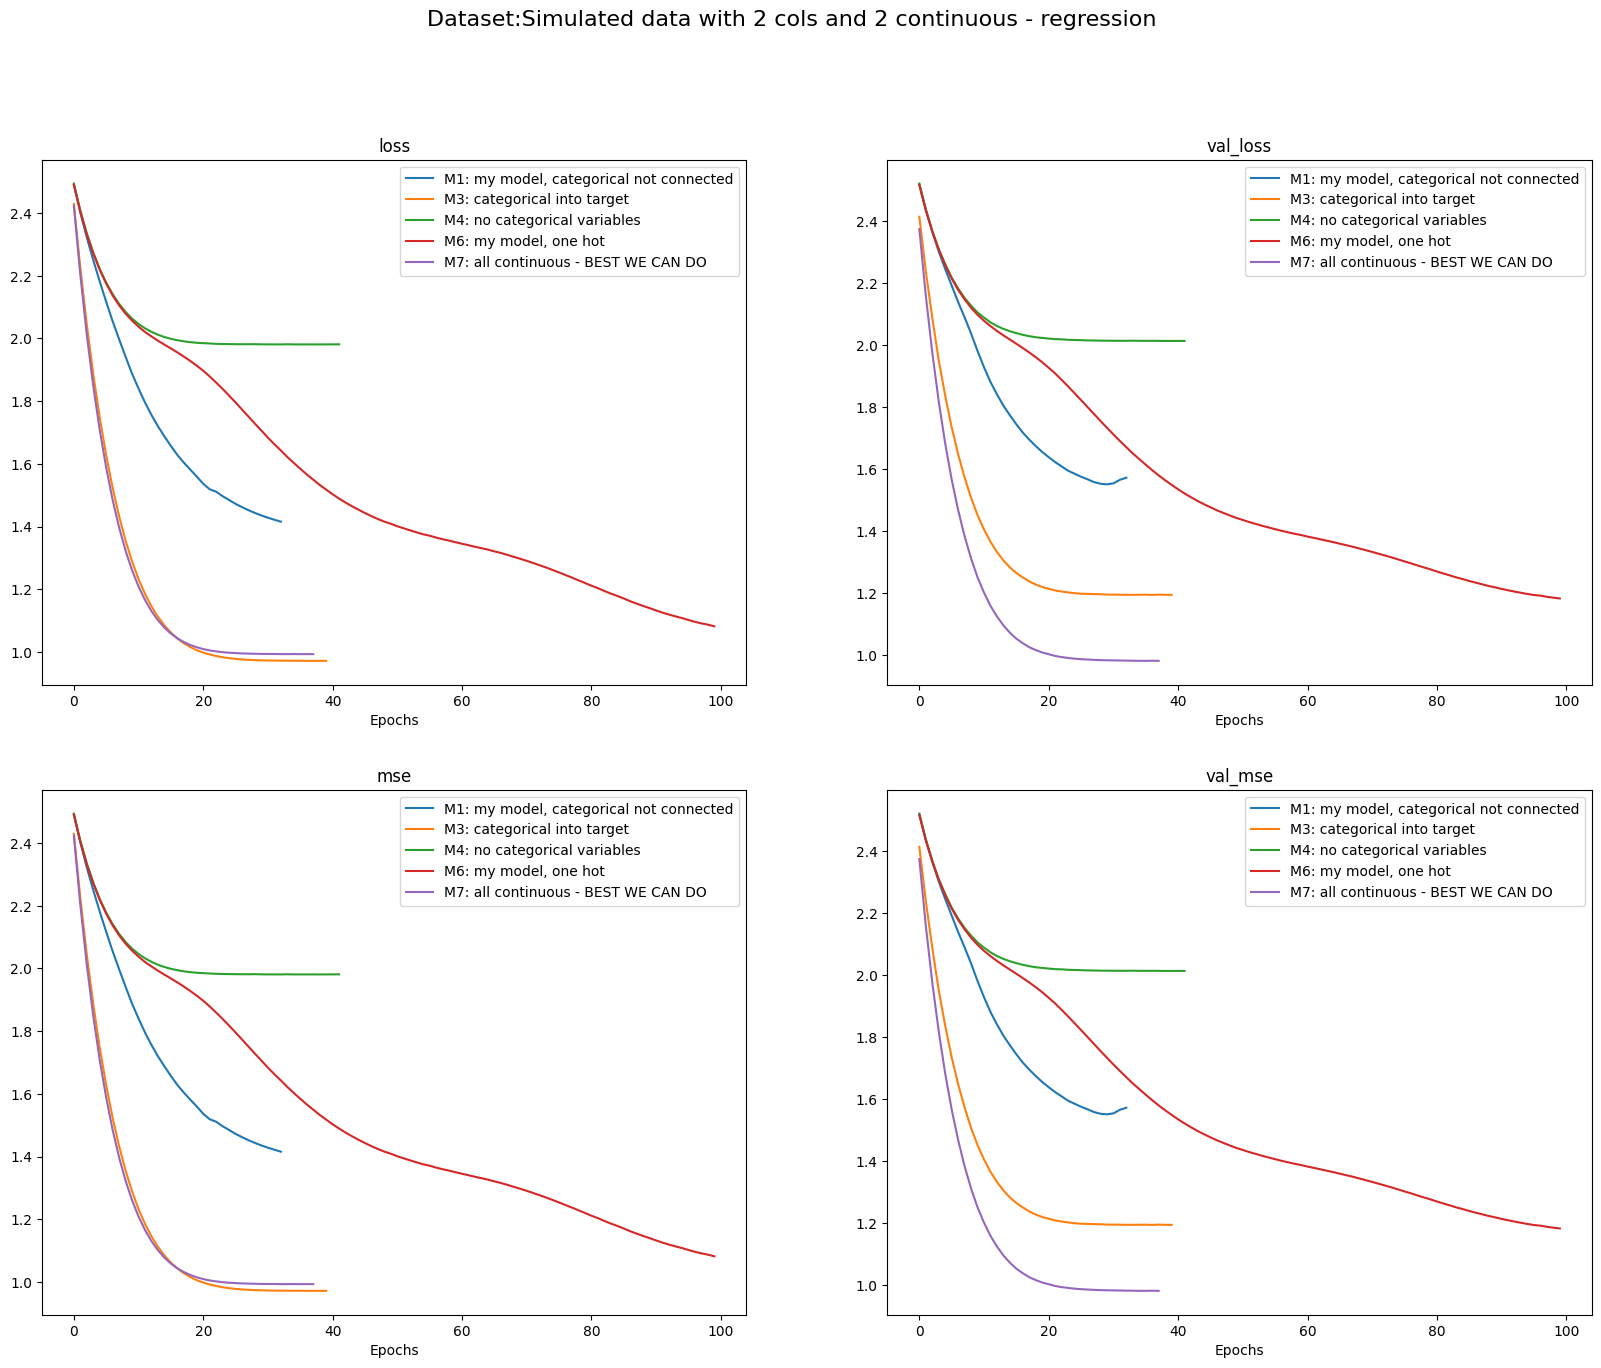

In [ ]:
index = 1
plt.figure(figsize=(20, 15))
for what in ['loss', 'val_loss','mse','val_mse']:
  plt.subplot(2, 2, index)
  index += 1

  plt.plot(history1.history[what], label='M1: my model, categorical not connected')

  plt.plot(history3.history[what], label='M3: categorical into target')
  plt.plot(history4.history[what], label='M4: no categorical variables')

  plt.plot(history6.history[what], label='M6: my model, one hot')
  if have_cont:
    plt.plot(history7.history[what], label='M7: all continuous - BEST WE CAN DO')
  plt.title(what)
  plt.xlabel('Epochs')
  plt.legend()

plt.suptitle('Dataset:' + which_dataset, fontsize=16)
plt.show()

In [ ]:
print('M1: \n')

print('beta = ' +str(model.get_weights()[-2].reshape(-1,)))
print('beta0 = ' +str(model.get_weights()[-1]))

print('M3: \n')

print('beta = ' +str(model_3.get_weights()[-2].reshape(-1,)))
print('beta0 = ' +str(model_3.get_weights()[-1]))

print('M4: \n')

print('beta = ' +str(model_4.get_weights()[-2].reshape(-1,)))
print('beta0 = ' +str(model_4.get_weights()[-1]))

print('M6: \n')

print('beta = ' +str(model_onehot.get_weights()[-2].reshape(-1,)))
print('beta0 = ' +str(model_onehot.get_weights()[-1]))

print('M7: \n')

print('beta = ' +str(model_7.get_weights()[-2].reshape(-1,)))
print('beta0 = ' +str(model_7.get_weights()[-1]))

M1: 

beta = [-1.2217194   0.91256297  0.6981966   0.19045919]
beta0 = [0.14121342]
M3: 

beta = [0.95672065 0.7732183  0.6685165  0.17351769]
beta0 = [-0.03548233]
M4: 

beta = [0.70764446 0.19277044]
beta0 = [0.03392199]
M6: 

beta = [ 2.725709   -1.2776263   0.7279013   0.19748335]
beta0 = [-0.62382656]
M7: 

beta = [0.88209194 0.47880667 0.7255484  0.19472519]
beta0 = [0.0130011]
